# Keylogger Detection 

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Reading Data

In [3]:
df_dk=pd.read_csv('Keylogger_Detection.csv')
df_dk.head(5)

/home/aviraljain/.conda/envs/MLlibs/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (48,56) have mixed types.Specify dtype option on import or set low_memory=False.



,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


# Data Preparation

In [4]:
df_dk.dtypes

Unnamed: 0           int64
Flow ID             object
 Source IP          object
 Source Port       float64
 Destination IP     object
                    ...   
Idle Mean          float64
 Idle Std          float64
 Idle Max          float64
 Idle Min          float64
Class               object
Length: 86, dtype: object

In [5]:
Class_df = df_dk["Class"]
df_num = df_dk.select_dtypes(include=[np.number])
df_num = df_num.join(Class_df)

### Removing Columns

In [6]:
df_num.drop('Unnamed: 0', axis=1, inplace=True)

### Removing nan values

In [7]:
print(df_num.isna().sum().sum())
df_num=df_num.dropna()

879


In [8]:
df_num["label"]=df_num["Class"]
df_num.loc[df_num.label == "Benign", 'label'] = 0
df_num.loc[df_num.label == "Keylogger", 'label'] = 1
df_num.drop('Class', axis=1, inplace=True)
df_num.sample(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
230008,60962.0,443.0,6.0,235851.0,2.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
43784,57667.0,1900.0,17.0,3002492.0,4.0,0.0,688.0,0.0,172.0,172.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
368048,36026.0,443.0,6.0,5623648.0,24.0,32.0,2017.0,36092.0,1172.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
402040,42841.0,443.0,6.0,95720904.0,629.0,943.0,6678.0,1220325.0,411.0,0.0,...,20.0,430316.0,0.0,430316.0,430316.0,6955304.0,0.0,6955304.0,6955304.0,0
68271,51784.0,80.0,6.0,1460052.0,2.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Distribution Classes

In [9]:
df_num.groupby('label').size()

label
0    308813
1    214782
dtype: int64

# Remove Useless Features

In [10]:
for col in (df_num.iloc[:,:-1].columns):
    if(df_num[col].min()==df_num[col].max()):
            df_num.drop(col, axis=1, inplace=True)

# Feature Scaling

In [11]:
# Normalization OR Standardization
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
    #df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

for i in (df_num.iloc[:,:-1].columns):
    standardize (df_num,i)

df_num.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,-0.210447,-0.368579,-0.468868,0.042412,-0.004811,-0.036722,-0.013233,-0.038629,-0.021233,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
1,0.828487,-0.368579,-0.468868,-0.465677,0.945480,0.575336,-0.004001,0.556642,0.815442,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
2,-2.027848,2.839488,-0.468868,-0.483831,-0.076338,-0.055364,-0.018437,-0.046536,-0.435509,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
3,-0.821057,-0.393449,2.036972,-0.460353,-0.086556,-0.052257,-0.018736,-0.046050,-0.478832,0.522899,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
4,0.759549,-0.368579,-0.468868,-0.166949,-0.066120,-0.055364,-0.019463,-0.046536,-0.584432,-0.212203,...,0.004135,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0


In [12]:
target=['label']
features = [c for c in df_num.columns if c!="label"]

# Split DataSet

In [13]:
X = df_num[features].values # Features
y = df_num[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((523595, 67), (523595, 1))

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((418876, 67), (104719, 67), (418876, 1), (104719, 1))

# Build Model - LGBM

In [16]:
lgb_train = lgb.Dataset(X_train, y_train,feature_name=features)
lgb_valid = lgb.Dataset(X_test, y_test,feature_name=features)

In [17]:
params= {
        'objective': 'binary',
        'metric': 'auc',
        'seed': 42,
        'learning_rate': 0.05,
        'max_bin': 850,
        'num_leaves': 70
        }

model = lgb.train(params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_valid],
                  verbose_eval=100,
                  num_boost_round=10000,
                  early_stopping_rounds=10
                )

/home/aviraljain/.conda/envs/MLlibs/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/aviraljain/.conda/envs/MLlibs/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/aviraljain/.conda/envs/MLlibs/lib/python3.6/site-packages/lightgbm/basic.py:179: UserWarning:

Converting column-vector to 1d array



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 171835, number of negative: 247041
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44105
[LightGBM] [Info] Number of data points in the train set: 418876, number of used features: 67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410229 -> initscore=-0.363020
[LightGBM] [Info] Start training from score -0.363020
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.792277	valid_1's auc: 0.786866
[200]	training's auc: 0.832535	valid_1's auc: 0.822626
[300]	training's auc: 0.857687	valid_1's auc: 0.844797
[400]	training's auc: 0.877235	valid_1's auc: 0.862485
[500]	training's auc: 0.892568	valid_1's auc: 0.876049
[60

## Evaluation

In [18]:
y_pred = model.predict(X_test)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

AUC: 0.988


# Build Model - Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train,y_train)


/home/aviraljain/.conda/envs/MLlibs/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(random_state=42)

## Evaluation

In [20]:

y_pred=rf.predict(X_test)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

AUC: 0.974


# Feature importance (Using LGBM Model)

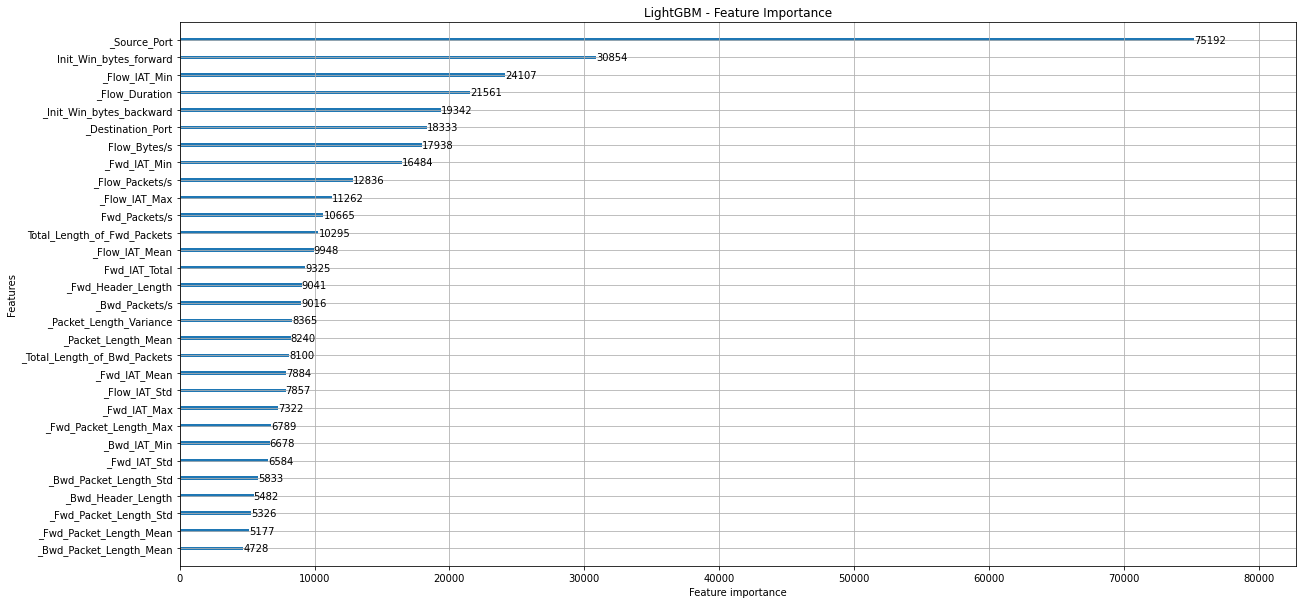

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
lgb.plot_importance(model, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

# Feature importance (Using Random Forest Model)

In [27]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Keep only top 30 features
    fi_df = fi_df.iloc[:30,:]

    # Add grid
    plt.style.use('seaborn-whitegrid')

    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')

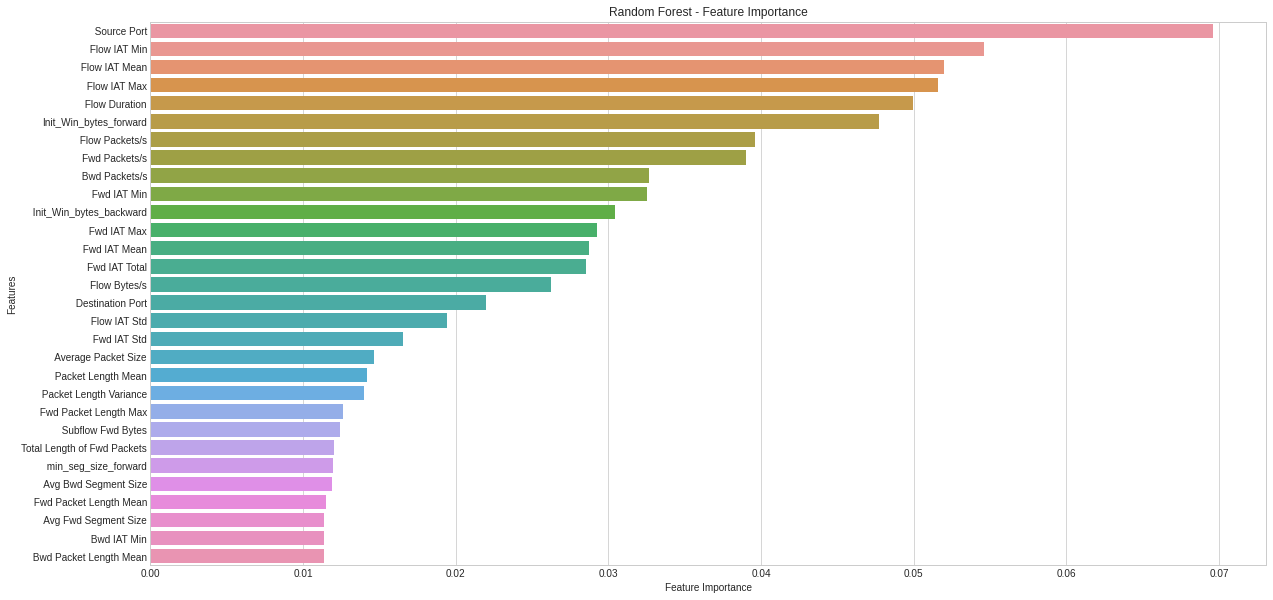

In [28]:
plot_feature_importance(rf.feature_importances_,features,'Random Forest')